Project Description:

- Download any dataset from Kaggle that contains chat data to conduct natural language processing.
- Load 2 tables of CSV data into a SQL database of your choice
- Optimize your database by creating indexes and primary keys on appropriate columns
- Add a new column of data that has not been included in the csv
- Conduct any type of NLP (language detection, sentiment analysis, tokenization, etc.) and add to the database
- Connect to database from Python, select some columns database and produce a visualization/analysis of it.

___
**Important note**: Although I had several questions regarding the project description (email sent to eduonix support - ticket 5623271728) and had some doubt about the use of SQL for this specific ML course, I still tried to finalize the project, resulting in the elaboration below.

___
<span style="color:green">**1. Download any dataset from Kaggle that contains chat data to conduct natural language processing.**</span>

For the dataset I choose for the Teld talks set, as can be found on Kaggle:
https://www.kaggle.com/rounakbanik/ted-talks

Goal is to match the highest rated category with NLP analysis on the transcripts.

___
<span style="color:green">**2. Load 2 tables of CSV data into a SQL database of your choice**</span>

Both ted_main.csv and transcripts.csv will be loaded into a sqlite database using sqlalchemy

In [13]:
from sqlalchemy import create_engine
import pandas as pd
from termcolor import colored

engine = create_engine('sqlite:///tedtalk.db', echo=False)
conn = engine.connect()

with open('ted_main.csv', 'r', encoding="utf-8") as file:
    data_df = pd.read_csv(file, encoding='utf-8')
data_df.to_sql('ted_main', con=engine, index=False, if_exists='replace')

with open('transcripts_unique.csv', 'r', encoding="utf-8") as file:
    data_df = pd.read_csv(file, encoding='utf-8')
data_df.to_sql('transcripts', con=engine, index=False, if_exists='replace')

# check if tables are loaded indeed
print(colored('tables:\n', 'blue'), engine.table_names(), '\n')

# check first line of ted_main
sql_text = 'SELECT * FROM ted_main LIMIT 1'
result = conn.execute(sql_text).fetchall()
print(colored('1st line table ted_main:\n', 'blue'), result, '\n')

# check first line of transcripts
sql_text = 'SELECT * FROM transcripts LIMIT 1'
result = conn.execute(sql_text).fetchall()
print(colored('1st line table transcripts:\n', 'blue'), result, '\n')

tables:
 ['ted_main', 'transcripts'] 

1st line table ted_main:
 [(4553, 'Sir Ken Robinson makes an entertaining and profoundly moving case for creating an education system that nurtures (rather than undermines) creativity.', 1164, 'TED2006', 1140825600, 60, 'Ken Robinson', 'Ken Robinson: Do schools kill creativity?', 1, 1151367060, "[{'id': 7, 'name': 'Funny', 'count': 19645}, {'id': 1, 'name': 'Beautiful', 'count': 4573}, {'id': 9, 'name': 'Ingenious', 'count': 6073}, {'id': 3,  ... (370 characters truncated) ... unt': 4439}, {'id': 25, 'name': 'OK', 'count': 1174}, {'id': 26, 'name': 'Obnoxious', 'count': 209}, {'id': 10, 'name': 'Inspiring', 'count': 24924}]", '[{\'id\': 865, \'hero\': \'https://pe.tedcdn.com/images/ted/172559_800x600.jpg\', \'speaker\': \'Ken Robinson\', \'title\': \'Bring on the learning r ... (1597 characters truncated) ... keep kids in poverty", \'duration\': 830, \'slug\': \'kandice_sumner_how_america_s_public_schools_keep_kids_in_poverty\', \'viewed_count\': 

___
<span style="color:green">**3. Optimize your database by creating indexes and primary keys on appropriate columns**</span>

As the ted talk URL is unique and also available in both tables (it defines the join), these will be the primary keys. I don't see any need to index any other columns than the primary keys.

Unfortunately sqlite only allows added primary key on creating table, so I have to copy the contents to a new table.

During this exercise it appeared that 3 shows where duplicated in the transcripts, preventing unique keys. The following duplicates have been removed from the original __*transcripts.csv*__:
- brene_brown_listening_to_shame
- jonathan_haidt_humanity_s_stairway_to_self_transcendence
- rob_reid_the_8_billion_ipod

The result has been saved to the file __*transcripts_unique.csv*__

In [14]:
sql_text = 'ALTER TABLE ted_main RENAME TO ted_main_old;'
conn.execute(sql_text)
sql_text = 'CREATE TABLE ted_main ('
sql_text += '    comments           BIGINT,'
sql_text += '    description        TEXT,'
sql_text += '    duration           BIGINT,'
sql_text += '    event              TEXT,'
sql_text += '    film_date          BIGINT,'
sql_text += '    languages          BIGINT,'
sql_text += '    main_speaker       TEXT,'
sql_text += '    name               TEXT,'
sql_text += '    num_speaker        BIGINT,'
sql_text += '    published_date     BIGINT,'
sql_text += '    ratings            TEXT,'
sql_text += '    related_talks      TEXT,'
sql_text += '    speaker_occupation TEXT,'
sql_text += '    tags               TEXT,'
sql_text += '    title              TEXT,'
sql_text += '    url                TEXT   PRIMARY KEY,'
sql_text += '    views              BIGINT'
sql_text += ');'
conn.execute(sql_text)
sql_text = 'INSERT INTO ted_main SELECT * FROM ted_main_old;'
conn.execute(sql_text)
sql_text = 'DROP TABLE ted_main_old'
conn.execute(sql_text)
sql_text = 'CREATE INDEX url_index1 ON ted_main (url)'
conn.execute(sql_text)

from sqlalchemy import Table, MetaData

meta = MetaData()
table = Table('ted_main', meta, autoload=True, autoload_with=engine)
result = table.primary_key.columns.values()[0].name
print(colored('Primary key of table ted_main:\n', 'blue'), result, '\n')

from sqlalchemy.engine import reflection

insp = reflection.Inspector.from_engine(engine)
print(colored('Index of table ted_main:', 'blue'))
for index in insp.get_indexes('ted_main'):
    print(index)

sql_text = 'ALTER TABLE transcripts RENAME TO transcripts_old;'
conn.execute(sql_text)
sql_text = 'CREATE TABLE transcripts ('
sql_text += '    transcript TEXT,'
sql_text += '    url        TEXT PRIMARY KEY'
sql_text += ');'
conn.execute(sql_text)
sql_text = 'INSERT INTO transcripts SELECT * FROM transcripts_old WHERE url LIKE "http%";'
conn.execute(sql_text)
sql_text = 'DROP TABLE transcripts_old'
conn.execute(sql_text)
sql_text = 'CREATE INDEX url_index2 ON transcripts (url)'
conn.execute(sql_text)

table = Table('transcripts', meta, autoload=True, autoload_with=engine)
result = table.primary_key.columns.values()[0].name
print(colored('Primary key of table transcripts:\n', 'blue'), result, '\n')

insp = reflection.Inspector.from_engine(engine)
print(colored('Index of table transcripts:', 'blue'))
for index in insp.get_indexes('transcripts'):
    print(index)

Primary key of table ted_main:
 url 

Index of table ted_main:
{'name': 'url_index1', 'column_names': ['url'], 'unique': 0}
Primary key of table transcripts:
 url 

Index of table transcripts:
{'name': 'url_index2', 'column_names': ['url'], 'unique': 0}


___
<span style="color:green">**4.Add a new column of data that has not been included in the csv**</span>

Here I have chosen to create a category out of the review column. The category with the highest counts in the reviews column is being assigned.

In [15]:
# Adding the column
sql_text = "ALTER TABLE ted_main ADD category TEXT;"
result = conn.execute(sql_text)
print(colored('Column "category" added', 'blue'))


Column "category" added


In [16]:
def max_count(reviews):
    reviews = reviews[2:-2]
    l_reviews = reviews.split("}, {")
    max = 0
    category = "DUMMY"
    for review in l_reviews:
        detail = review.split(",")
        count = int(detail[2][detail[2].find(':') + 2:])
        if count > max:
            category = detail[1][detail[1].find(':') + 2:]
            max = count
    return category


counter = 0
sql_text = 'SELECT url, ratings FROM ted_main'
result = conn.execute(sql_text).fetchall()
for row in result:
    cat = max_count(row[1])
    sql_text = "UPDATE ted_main SET category = " \
               + cat + " WHERE url = '" + row[0] + "';"
    conn.execute(sql_text)
    counter += 1
print(colored('Updated ' + str(counter) + ' rows', 'blue'))

sql_text = 'SELECT category FROM ted_main'
result = conn.execute(sql_text).fetchall()
print(colored('\nList of all most counted categories:', 'blue'))

category_set = set()
for category in result:
    category_set.add(category.values()[0])
for category in category_set:
    print(category)

Updated 2550 rows

List of all most counted categories:
Inspiring
Jaw-dropping
Funny
Courageous
Obnoxious
Fascinating
Beautiful
Unconvincing
Informative
Longwinded
Confusing
Ingenious
Persuasive
OK


___
<span style="color:green">**5.Conduct any type of NLP (language detection, sentiment analysis, tokenization, etc.) and add to the database**</span>

First the query is read into a dataframe and split into a test/train set. Then a vectorizer is being used (with remal of the stopwords), followed by a TFIDF transformation. A multinomial Naive Bains is being used to train the model.

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score

sql_text = "SELECT ted_main.category, transcripts.transcript FROM ted_main INNER JOIN transcripts ON ted_main.url = transcripts.url;"
dataset = pd.read_sql_query(sql_text, conn)
train, test = train_test_split(dataset, test_size=0.2, random_state=0)

count_vect = CountVectorizer(stop_words='english')

X_train_counts = count_vect.fit_transform(train.transcript)  # X_train_counts.shape

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tfidf = tf_transformer.transform(X_train_counts)

model = MultinomialNB(alpha=0.001)
model.fit(X_train_tfidf, train.category)

X_test_counts = count_vect.transform(test.transcript)
X_test_tfidf = tf_transformer.transform(X_test_counts)
predicted = model.predict(X_test_tfidf)
print(colored('Accuracy score:', 'blue'))
print(accuracy_score(test.category, predicted))

Accuracy score:
0.5273833671399595


The accuracy score is around **53%**, which seems not very good. This might very well be due to the fact that the categories e.g. "inspirational", "funny", "informative", "confusing" are not only based on single words, but also actual content and of course the way the presentation is being held.

Optimization of the algorithm has been done by changing the alpha factor and removing the stop-words.


___
<span style="color:green">**6.Connect to database from Python, select some columns database and produce a visualization/analysis of it.**</span>

Of course I have been connected to the database all the time as I used sqlalchemy to create and manipulate the sqlite database.

For the visualisation I decided to show the relation between number of views and the number of times the talk was rated as "Funny".

To be sure that the funny count makes sense, the funny count is converted to a percentage of the total counts. To prevent a skewed result, reviews with a total review count of less than 1000 have been omitted.

In [18]:
# Adding the columns
sql_text = "ALTER TABLE ted_main ADD total_reviews BIGINT;"
result = conn.execute(sql_text)
print(colored('Columns "total_review" added', 'blue'))

sql_text = "ALTER TABLE ted_main ADD funny_count BIGINT;"
result = conn.execute(sql_text)
print(colored('Columns "funny_count" added', 'blue'))

sql_text = "ALTER TABLE ted_main ADD insp_count BIGINT;"
result = conn.execute(sql_text)
print(colored('Columns "insp_count" added', 'blue'))

Columns "total_review" added
Columns "funny_count" added
Columns "insp_count" added


Updated 2550 rows


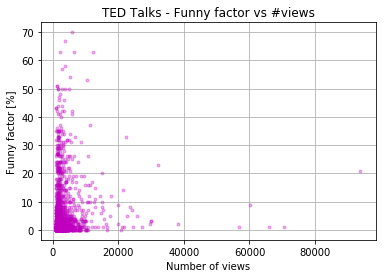

In [19]:
def funny_total_parser(reviews):
    reviews = reviews[2:-2]
    l_reviews = reviews.split("}, {")
    total_count = 0
    funny_count = 0
    insp_count = 0
    for review in l_reviews:
        detail = review.split(",")
        count = int(detail[2][detail[2].find(':') + 2:])
        total_count += count
        category = detail[1][detail[1].find(':') + 2:]
        if category == "'Funny'":
            funny_count = count
        if category == "'Inspiring'":
            insp_count = count
    return str(total_count), str(funny_count), str(insp_count)

counter = 0
sql_text = 'SELECT url, ratings FROM ted_main'
result = conn.execute(sql_text).fetchall()
for row in result:
    total_count, funny_count, insp_count = funny_total_parser(row[1])
    sql_text = "UPDATE ted_main SET total_reviews = " \
               + total_count + ", funny_count = " \
               + funny_count + ", insp_count = " \
               + insp_count + " WHERE url = '" + row[0] + "';"
    conn.execute(sql_text)
    counter += 1
print(colored('Updated ' + str(counter) + ' rows', 'blue'))

sql_text = 'SELECT total_reviews, published_date, ROUND(funny_count/(total_reviews*1.0)*100)' \
            + ' AS funny_factor, ROUND(insp_count/(total_reviews*1.0)*100)' \
            + ' AS insp_factor FROM ted_main WHERE total_reviews > 1000;'

query_dataset = pd.read_sql_query(sql_text, conn)
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(query_dataset.total_reviews, query_dataset.funny_factor,'m.',alpha=0.3)

ax.set(xlabel='Number of views', ylabel='Funny factor [%]',
       title='TED Talks - Funny factor vs #views')
ax.grid()
plt.show()



Well this is disappointing. I was hoping that the funnier people think the Ted Talk is, the more views there are, but it is easy to see that this is not true.

As Ted Talks claims to be inspirational, my hope was on the inspirational review count, resulting in the plot below:

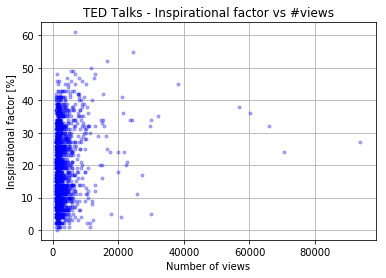

In [20]:
fig, ax = plt.subplots()
ax.plot(query_dataset.total_reviews, query_dataset.insp_factor,'b.',alpha=0.3)

ax.set(xlabel='Number of views', ylabel='Inspirational factor [%]',
       title='TED Talks - Inspirational factor vs #views')
ax.grid()
plt.show()

Also here you see that the review count "inspirational" is not directly related to the number of views. Of course the number of views is also depending on the published date: the earlier it is published, the more time there has been to view the show...

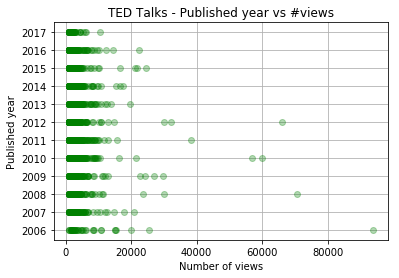

In [21]:
import datetime
query_dataset['published_year'] = query_dataset['published_date']. \
    apply(lambda x: datetime.datetime.fromtimestamp( int(x)).strftime('%Y'))

fig, ax = plt.subplots()
ax.plot(query_dataset.total_reviews, query_dataset.published_year,'go',alpha=0.3)

ax.set(xlabel='Number of views', ylabel='Published year',
       title='TED Talks - Published year vs #views')
ax.grid()
plt.show()

___ 
Well that is still disappointing... Let's take a look at the correlation matrix:

In [22]:
corr_matrix = query_dataset.corr()
print (corr_matrix)

                total_reviews  published_date  funny_factor  insp_factor
total_reviews        1.000000       -0.129195      0.052874     0.156792
published_date      -0.129195        1.000000     -0.110687     0.179885
funny_factor         0.052874       -0.110687      1.000000    -0.269423
insp_factor          0.156792        0.179885     -0.269423     1.000000


Here we can see that the correlation coefficients between the data shown in plots above are quite low. One of the bigger reasons might be that once a show has a certain number of views, people are triggered to view the show, simply because of the number of views, which in turn increases even more...

The top 10 most viewed TED talks below show some of the researched parameters. I guess I just have to watch them to know why they are so popular....

In [23]:
sql_text = 'SELECT title, category, ROUND(funny_count/(total_reviews*1.0)*100)' \
            + ' AS funny_factor, ROUND(insp_count/(total_reviews*1.0)*100)' \
            + ' AS insp_factor  FROM ted_main ORDER BY views DESC LIMIT 10'
result = conn.execute(sql_text).fetchall()
query_dataset = pd.read_sql_query(sql_text, conn)
print(query_dataset)

                                               title     category  \
0                        Do schools kill creativity?    Inspiring   
1           Your body language may shape who you are    Inspiring   
2                   How great leaders inspire action    Inspiring   
3                         The power of vulnerability    Inspiring   
4             10 things you didn't know about orgasm        Funny   
5         How to speak so that people want to listen  Informative   
6                               My stroke of insight    Inspiring   
7                               Why we do what we do    Inspiring   
8  This is what happens when you reply to spam email        Funny   
9  Looks aren't everything. Believe me, I'm a model.   Courageous   

   funny_factor  insp_factor  
0          21.0         27.0  
1           1.0         32.0  
2           1.0         38.0  
3           9.0         36.0  
4          37.0          1.0  
5           5.0         24.0  
6           1.0        

___
That's it, now close the SQL connection...

In [24]:
# close sql connection
conn.close()